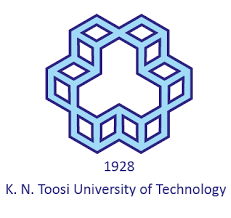
# ***LiDar Assignment 02: PointCloud Supervised classification***

**KNTU G.E engineering faculty _ 2023 November**

*Hasti Rafiei Nia* 

*Student Number : 9926683*


Importing libraries.

In [70]:
import os
import laspy
import numpy as np
import open3d as o3d
import matplotlib as mpl
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
mpl.rc('font', family ='Times New Roman')
from sklearn.preprocessing import MinMaxScaler
from sklearn. tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Change directory & read point cloud (pc) data. 

In [71]:
os.chdir('D:/')
las = laspy.read('nonground_training.Las')
las_f = laspy.read('Training_FlatRoof.Las')
las_s = laspy.read('Training_SlopingRoof.Las')
las_t = laspy.read('Training_Tree.Las')
las_g = laspy.read('Training_Ground.Las')

Convert las to numpy array format.


In [72]:
pc = np.vstack([las.X, las.Y, las.Z]).transpose()
pc_s = np.vstack([las_s.X, las_s.Y, las_s.Z]).transpose()
pc_f = np.vstack([las_f.X, las_f.Y, las_f.Z]).transpose()
pc_t = np.vstack([las_t.X, las_t.Y,las_t.Z]).transpose()
pc_g = np.vstack([las_g.X, las_g.Y, las_g.Z]).transpose()
print(pc.shape, pc_s.shape, pc_t.shape, pc_g.shape)

(511627, 3) (1768, 3) (6026, 3) (998, 3)


3D Point cloud visualization.

In [73]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)
o3d.visualization.draw_geometries([pcd])

pcd_s = o3d.geometry.PointCloud()
pcd_s.points = o3d.utility.Vector3dVector(pc_s)
o3d.visualization.draw_geometries([pcd_s])

pcd_f = o3d.geometry.PointCloud()
pcd_f.points = o3d.utility.Vector3dVector(pc_f)
o3d.visualization.draw_geometries([pcd_f])
 
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(pc_t)
o3d.visualization.draw_geometries([pcd_t])

pcd_g = o3d.geometry.PointCloud()
pcd_g.points = o3d.utility.Vector3dVector(pc_g)
o3d.visualization.draw_geometries([pcd_g])

Set labels for sample points.
* 1-class Sloping Roof.


In [74]:
set_s = set(map(tuple, pc_s))
idx_s = [tuple(point) in set_s for point in pc]
print(pc_s.shape, pc[idx_s].shape)

(1768, 3) (1768, 3)


* 1-class Flat Roof.

In [75]:
set_f = set(map(tuple, pc_f))
idx_f = [tuple(point) in set_f for point in pc]
print(pc_f.shape, pc[idx_f].shape)

(254, 3) (254, 3)


* 2-class Tree.

In [76]:
set_t = set(map(tuple,pc_t))
idx_t = [tuple(point) in set_t for point in pc]
print(pc_t.shape, pc[idx_t].shape)

(6026, 3) (6026, 3)


* 3-class Ground. 

In [77]:
set_g = set(map(tuple,pc_g))
idx_g = [tuple(point) in set_g for point in pc]
print(pc_g.shape, pc[idx_g].shape)

(998, 3) (998, 3)


Defining label column.

In [78]:
labels = np.zeros((len(pc), 1))
pc_new = np.hstack([pc, labels])
print(pc_new.shape)

(511627, 4)


Set labels as: 
1 = building

2 = tree

3 = ground

0 = unclassified points


In [79]:
pc_new[idx_s,3] = 1 
pc_new[idx_f,3] = 2
pc_new[idx_t,3] = 3 
pc_new[idx_g,3] = 4 
Counter(pc_new[:,3])

Counter({0.0: 502581, 4.0: 998, 3.0: 6026, 1.0: 1768, 2.0: 254})

Feature extraction. 

In [80]:
intensity = las.intensity
intensity

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [81]:
ind = ((las.blue - las.green)/(las.blue + las.green))
ind

array([0.56692913, 0.79527559, 0.69291339, ..., 0.25984252, 0.25984252,
       0.25984252])

Creation Data(feature) frame & preprocessing.

In [82]:
features = np.stack([las.Z, ind]).transpose()
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

sample_pc = pc_new[pc_new[:, 3] != 0]
sample_features = features[pc_new[:, 3] !=0]
print (sample_pc.shape, sample_features.shape)

(9046, 4) (9046, 2)


Train_Test split.


In [83]:
x = sample_features
y = sample_pc[:,3]
print(x.shape, y.shape)

(9046, 2) (9046,)


In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
print("___Train Size____" , "\n")
print(x_train.shape, y_train.shape,"\n")
print("___Test Size_____","\n")
print(x_test.shape,y_test.shape)


___Train Size____ 

(6332, 2) (6332,) 

___Test Size_____ 

(2714, 2) (2714,)


Classification & visualization.


In [89]:
clf1 = RandomForestClassifier(n_estimators=800, max_depth=3, random_state=0)
clf1.fit(x_train, y_train)
pred_test_RF = clf1.predict(x_test)
pred_total_RF= clf1.predict(features)

Counter(pred_test_RF)
Counter(pred_total_RF)

classified_pc_RF = np.stack([las.X, las.Y, las.Z, pred_total_RF]).transpose()
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(classified_pc_RF)
o3d.visualization.draw_geometries([geom])

RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

Validation.


Confusion matrix.


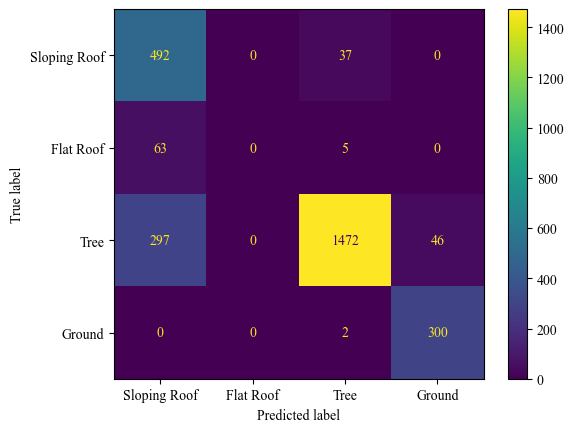

In [90]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test_RF)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
display_labels = ['Sloping Roof', 'Flat Roof', 'Tree', 'Ground'])
cm_display.plot()
plt.show()

Metric.

In [91]:
print(classification_report(y_test, pred_test_RF, target_names=['Sloping Roof', 'Flat Roof', 'Tree', 'Ground']))

              precision    recall  f1-score   support

Sloping Roof       0.58      0.93      0.71       529
   Flat Roof       0.00      0.00      0.00        68
        Tree       0.97      0.81      0.88      1815
      Ground       0.87      0.99      0.93       302

    accuracy                           0.83      2714
   macro avg       0.60      0.68      0.63      2714
weighted avg       0.86      0.83      0.83      2714



c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Exporting results.

In [92]:
output = laspy.create(point_format = las.header.point_format)
output.X = las.X
output.Y = las.Y
output.Z = las.Z
output.classification = classified_pc_RF[:,3]

out_name = 'supervised_RF.Las'
output.write(out_name)

Classification with SVM model.


In [93]:
model = SVC(kernel='linear', C=4, gamma='auto')
model.fit(x_train, y_train)
pred_test_SVM = model.predict(x_test)
pred_total_SVM = model.predict(features)

classified_pc_SVM = np.stack([las.X, las.Y, las.Z, pred_total_SVM]).transpose()
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(classified_pc_SVM)
o3d.visualization.draw_geometries([geom])

RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

Confusion Matrix.

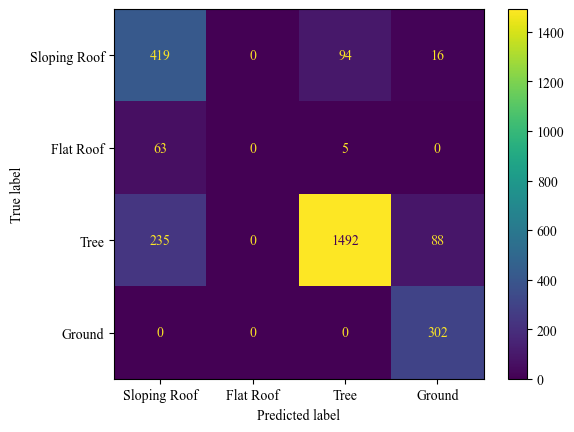

In [94]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test_SVM)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
display_labels = ['Sloping Roof', 'Flat Roof', 'Tree', 'Ground'])
cm_display.plot()
plt.show()

Metrics.

In [95]:
print("SVM Model Accuracy:", accuracy_score(y_test,pred_test_SVM),"\n")
print("Classification Report:")
print(classification_report(y_test, pred_test_SVM))

SVM Model Accuracy: 0.8154016212232866 

Classification Report:
              precision    recall  f1-score   support

         1.0       0.58      0.79      0.67       529
         2.0       0.00      0.00      0.00        68
         3.0       0.94      0.82      0.88      1815
         4.0       0.74      1.00      0.85       302

    accuracy                           0.82      2714
   macro avg       0.57      0.65      0.60      2714
weighted avg       0.82      0.82      0.81      2714



c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOME\anaconda3\envs\LiDar\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
output = laspy.create(point_format = las.header.point_format)
output.X = las.X
output.Y = las.Y
output.Z = las.Z
output.classification = classified_pc_SVM[:,3]

out_name = 'supervised_SVM.Las'
output.write(out_name)